In [1]:
import pandas as pd
import numpy as np 
import random
from tqdm import tqdm
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
col = sns.color_palette('Set2')
col

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [4]:
col2 = sns.color_palette('deep')
col2

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

# Reading data

In [5]:
data = pd.read_csv('Cell_a.csv')

In [6]:
data.shape

(2329133, 5)

Sorting the row of the dataframe according to the column 'Arrival_Time'.

In [7]:
data.sort_values(by = 'Arrival_Time', ascending = True, inplace = True)

# Setting parameters

In [8]:
N = 64    # number of servers
mi = 0.1  # processing power

Transforming the arrival time in seconds

In [9]:
data['Arrival_Time'] = data['Arrival_Time']*(10**(-6))

Computing the Service Time as the ratio between the value in the column 'CPU' and the processing power.

In [10]:
data['Service_Time'] = data['CPU']/mi

Drop the job with sum of the service time of all their tasks equal to zero.

In [11]:
sum_service_time = data.groupby('Job_ID')['Service_Time'].sum()
index_zero = sum_service_time[sum_service_time==0].index
data = data[~ data['Job_ID'].isin(index_zero)]

Scaling the arrival time by subtracting the minimum of the column from all the values of the column

In [12]:
data['Arrival_Time'] = data['Arrival_Time']-min(data['Arrival_Time'])

In [13]:
data.reset_index(inplace=True)
data.drop(['index'], axis='columns', inplace=True)

In [14]:
data.head()

,Job_ID,Task_ID,Arrival_Time,CPU,Memory,Service_Time
0,375000667413,0,0.000000,0.041851,0.001169,0.418510
1,375000669289,0,3.386741,0.024968,0.001179,0.249681
2,375000670586,0,5.968153,0.024176,0.001173,0.241756
3,375000670588,0,5.968166,0.019552,0.001163,0.195522
4,375000670590,0,6.016603,0.028044,0.001179,0.280437


In [15]:
data.shape

(2317575, 6)

# Data analysis

Checking if all the tasks of a job arrive at the same time.

In [16]:
a = pd.DataFrame(data.groupby('Job_ID')['Arrival_Time'].nunique())
len(a[a.Arrival_Time == 1]) == len(data['Job_ID'].unique())

True

Computing for each job the number of tasks that must be executed.

In [17]:
n = pd.DataFrame(data.groupby('Job_ID')['Task_ID'].count())
n.rename(columns = {'Task_ID': 'Num_of_tasks'}, inplace = True)
n.sort_values(by = 'Num_of_tasks', ascending=False)

,Num_of_tasks
Job_ID,
382441077815,2998
379553816302,2998
382388697819,2998
383486650431,2998
380629608648,2998
...,...
381794411667,1
381794411864,1
381794411974,1


Computing the probability that a job has only 1 task.

In [18]:
job_smaller_than_1 = len(n[n['Num_of_tasks']==1])/(len(n))
print('The probability that a job has only 1 task is: ', round(job_smaller_than_1,5)*100, '%')

The probability that a job has only 1 task is:  94.035 %


Computing the ECDF of the number of task per job.

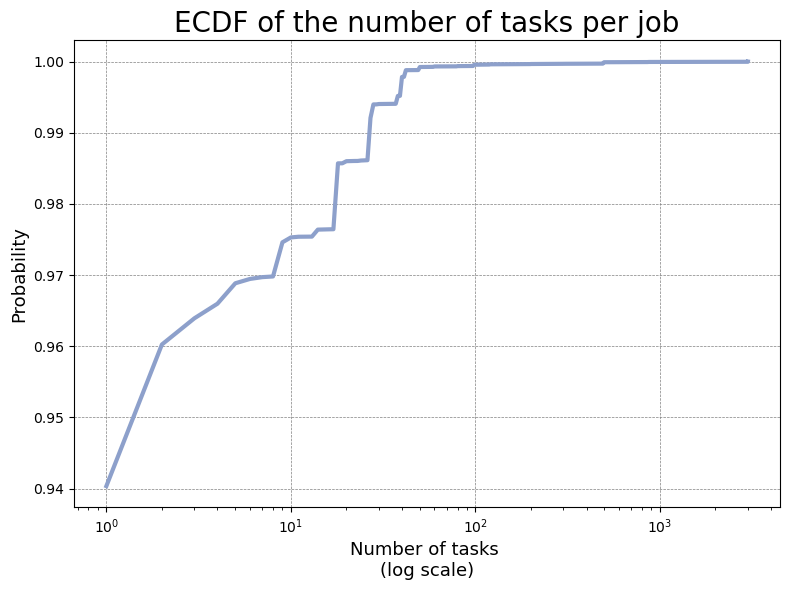

In [21]:
ecdf = ECDF(n['Num_of_tasks'])
x = np.sort(n['Num_of_tasks'])
y = ecdf(x)
plt.figure(figsize=(8,6), tight_layout=True)
plt.style.use('default')
plt.xscale('log')
plt.plot(x, y, '-', linewidth=3, color = col[2], label = 'r = 2')
plt.xlabel('Number of tasks \n(log scale)', size=13)
plt.ylabel('Probability', size=13)
plt.title('ECDF of the number of tasks per job', size=20)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show()

Histogram of the arrival time.

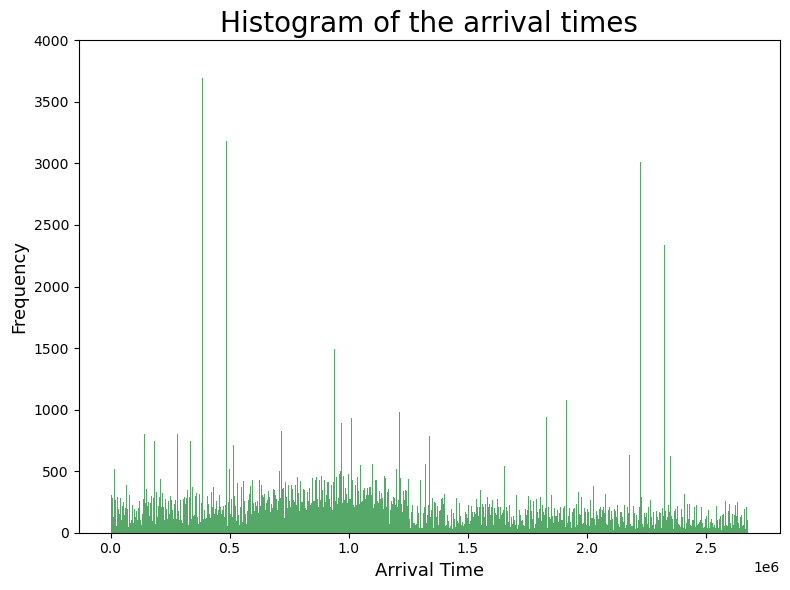

In [20]:
plt.figure(figsize=(8,6), tight_layout=True)
plt.hist(data['Arrival_Time'], bins=10000, color=col2[2], rwidth=1)
plt.xlabel('Arrival Time', size=13)
plt.ylabel('Frequency', size=13)
plt.title('Histogram of the arrival times', size=20)
plt.ylim((0,4000))
plt.show()

Histogram of the service time.

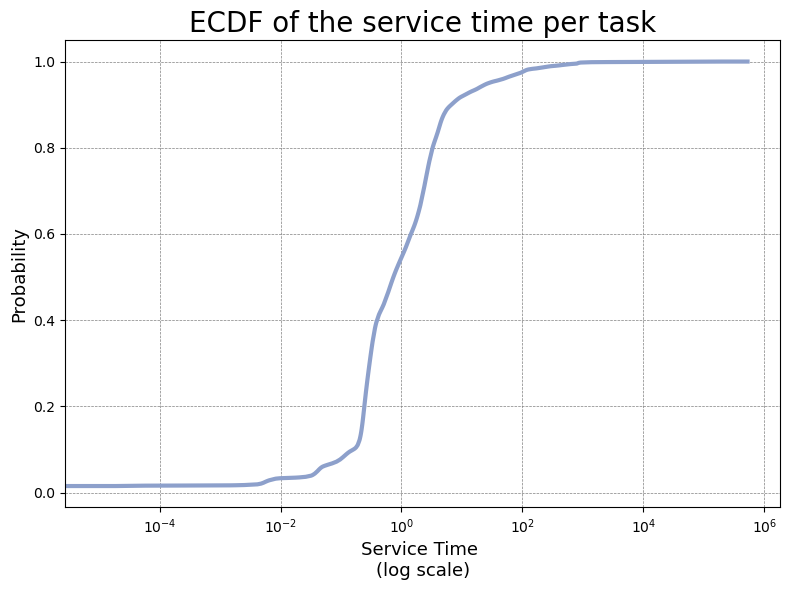

In [22]:
ecdf = ECDF(data['Service_Time'])
x = np.sort(data['Service_Time'])
y = ecdf(x)
plt.figure(figsize=(8,6), tight_layout=True)
plt.style.use('default')
plt.xscale('log')
plt.plot(x, y, '-', linewidth=3, color = col[2], label = 'r = 2')
plt.xlabel('Service Time \n(log scale)', size=13)
plt.ylabel('Probability', size=13)
plt.title('ECDF of the service time per task', size=20)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show()

# Baseline algorithm

In the baseline function we implement both the dispatching algorithm (LWL) and the scheduling algorithm (FCFS).

In [23]:
def baseline(data):
    
    servers = {i: [] for i in range(64)}
    T = [0 for i in range(64)]
    starting_execution_task = [] # for each task we save the starting execution time of the task in this list
    
    for i in tqdm(range(len(data))):
        
        free_servers = np.where(data['Arrival_Time'][i] >= T)[0] # choosing the index of the free server
        if len(free_servers) > 0: # if there are free server 
            j = random.sample(set(free_servers), 1)[0] # choosing random from them
    
            starting = data['Arrival_Time'][i] 
             # adding the starting time and the arrival time of the task i in the list T (total time of work for each server)
            T[j] = starting + data['Service_Time'][i]
            
        else: #if there aren't free server choosing the server with the shortest queue in the sense of time to work
            j = np.argmin(T)
            starting = T[j]
            T[j] = starting + data['Service_Time'][i]
            
        servers[j].append(i) # in the server j run the task i
        starting_execution_task.append(starting)
        
    return (T,servers,starting_execution_task)

In [24]:
T, servers, starting_execution_task = baseline(data)

100%|█████████████████████████████████████████████████████████████████████| 2317575/2317575 [02:01<00:00, 19035.90it/s]


# Metrics

## Rho

In [25]:
jobs = set(data['Job_ID'])

Computing the sum of the Service Time for each job.

In [27]:
tot_time = data.groupby('Job_ID')['Service_Time'].sum() 

Computing the rho values for the baseline algorithm fraction of time that the server k is busy serving tasks.

In [28]:
rho_1 = {}
for server in tqdm(range(64)):
    task_server = servers[server]
    rho_1[server] = sum(data['Service_Time'][servers[server]])/(T[server]-data['Arrival_Time'][task_server[0]])

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 39.69it/s]


In [29]:
rho_1_hat = np.mean(list(rho_1.values()))
rho_1_hat

0.5384996033030662

## L 

Computing the messaging load L for the baseline algorithm.

In [30]:
L_1 = {}
for task in tqdm(range(len(data))):
    L_1[task] = 2*N + 2

100%|███████████████████████████████████████████████████████████████████| 2317575/2317575 [00:01<00:00, 1523785.64it/s]


In [31]:
L_1_hat = np.mean(list(L_1.values()))
L_1_hat

130.0

## R and S

Adding the columns 'starting_execution_task' and 'Final' to the dataframe: 'starting_execution_task' contains the starting execution time for each task, 'Final' contains the final execution time for each task.

In [32]:
data['starting_execution_task']= starting_execution_task
data['Final']= data['starting_execution_task']+data['Service_Time']

In [33]:
end_time_per_job = data.groupby('Job_ID')['Final'].max()
first_task = data.groupby("Job_ID").first()

In [34]:
data.head(5)

,Job_ID,Task_ID,Arrival_Time,CPU,Memory,Service_Time,starting_execution_task,Final
0,375000667413,0,0.000000,0.041851,0.001169,0.418510,0.000000,0.418510
1,375000669289,0,3.386741,0.024968,0.001179,0.249681,3.386741,3.636422
2,375000670586,0,5.968153,0.024176,0.001173,0.241756,5.968153,6.209909
3,375000670588,0,5.968166,0.019552,0.001163,0.195522,5.968166,6.163688
4,375000670590,0,6.016603,0.028044,0.001179,0.280437,6.016603,6.297040


Computing R and S for the baseline algorithm.

In [35]:
R_1 = {}
S_1 = {}
for job in tqdm(jobs):
    R_1[job] = end_time_per_job[job]-first_task['Arrival_Time'][job]
    S_1[job] = R_1[job]/tot_time[job]

100%|█████████████████████████████████████████████████████████████████████| 1153439/1153439 [00:44<00:00, 25743.87it/s]


In [36]:
S_1_hat = np.mean(list(S_1.values()))
S_1_hat

1241639.3265850258

In [37]:
R_1_hat = np.mean(list(R_1.values()))
R_1_hat

27601.15769728951

# Alternative algorithm

Our alternative dispatching and scheduling algorithms.

In [41]:
data = data.merge(n, left_on = 'Job_ID', right_on = 'Job_ID') 

In [42]:
Final_Time = np.zeros(len(data))
Num_of_tasks = np.array(data['Num_of_tasks'])
Service_Time = np.array(data['Service_Time'])
Arrival_Time = np.array(data['Arrival_Time'])
server = np.zeros(len(data))
task_server = {i: [] for i in range(64)}
tot = np.zeros(64)

In [43]:
L_2 = np.zeros(len(data))

In [44]:
def join_below_threshold(data):
    
    available = [s for s in range(64)] # available servers
    threshold = 39
    
    for i in tqdm(range(len(data))):
        left_work = tot-Arrival_Time[i]
    
        if len(available) > 0: # if there are available servers
            j = random.sample(available, 1)[0]
            if left_work[j]+Service_Time[i]>threshold:
                available.remove(j)
        else:
            L_2[i] = 64*2 #counting 64*2 messages each time that all the servers are over the threshold
            non_empty_servers = np.where(left_work>0)[0]
            if len(non_empty_servers)>=30:
                samples = random.sample(list(non_empty_servers),30)
                threshold = np.min(left_work[samples])
                available = list(np.where(left_work <= threshold)[0])
            elif len(non_empty_servers)>0 and len(non_empty_servers)<30:
                samples = random.sample(list(non_empty_servers),len(non_empty_servers))
                threshold = np.min(left_work[samples])
                available = list(np.where(left_work <= threshold)[0])
            else:
                available = [s for s in range(64)]
                threshold = 39
            j = random.sample(available, 1)[0]
            if left_work[j]+Service_Time[i]>threshold:
                available.remove(j)
        scheduling_algo(i, j)
        
    return 

In [45]:
def scheduling_algo(i, j): 
    
    server[i] = j
    task = task_server[j] 
    a_t = data['Arrival_Time'][i]
    
    # If the queue is already empty
    if len(task) == 0:
        Final_Time[i] = a_t + Service_Time[i] 
        task.append(i)
        tot[j] = a_t + Service_Time[i] 
    
    # If the queue is not empty
    else:
        already_executed = np.where(Final_Time[task] <= a_t)[0]
        k = len(task)
        for s in range(len(already_executed)):
            task.pop(0)
        if (len(already_executed) > 0) and len(task)>=1:
            
            if len(task)==1:
                Final_Time[i] = Final_Time[task[-1]] + Service_Time[i]
                task.append(i)
                tot[j] = tot[j] + Service_Time[i]
            
            else:
                list_ind = np.where(Service_Time[task[1:]] > Service_Time[i])[0]
                if len(list_ind) > 0:
                    ind = list_ind[0]
                    task.insert(ind+1, i)
                    Final_Time[i] = Final_Time[task[ind]] + Service_Time[i]
                    Final_Time[task[ind+2:]] = Final_Time[task[ind+2:]] + Service_Time[i] 
                    tot[j] += Service_Time[i]
                    
                else:
                    Final_Time[i] = Final_Time[task[-1]] + Service_Time[i]
                    task.append(i)
                    tot[j] += Service_Time[i]
                    

                
        elif (len(already_executed) > 0) and len(task)==0:
            task.append(i)
            Final_Time[i] = a_t + Service_Time[i]
            tot[j] = a_t + Service_Time[i] 
        
        elif len(already_executed) == 0:
            Final_Time[i] = Final_Time[task[-1]] + Service_Time[i]
            task.append(i)
            tot[j] += Service_Time[i]            
    
    return

In [46]:
join_below_threshold(data)

100%|██████████████████████████████████████████████████████████████████████| 2317575/2317575 [04:26<00:00, 8696.03it/s]


In [47]:
tot_time = data.groupby('Job_ID')['Service_Time'].sum()
data['Final_Time'] = Final_Time
data['Server'] = server
end_time_per_job = data.groupby("Job_ID")['Final_Time'].max()
first_task = data.groupby("Job_ID").first()
jobs = set(data['Job_ID'])

100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 5307.15it/s]


## R, S, L, rho

Computing R, S, L, rho for the customize algorithm.

In [ ]:
R_2 = {}
S_2 = {}
for job in tqdm(jobs):
    R_2[job] = end_time_per_job[job]-first_task['Arrival_Time'][job]
    S_2[job] = R_2[job]/tot_time[job]
R_2_hat = np.mean(list(R_2.values()))
S_2_hat = np.mean(list(S_2.values()))

In [ ]:
active_time = data.groupby('Server')['Service_Time'].sum()
first_task = data.groupby("Server").first()
rho_2 = {}
for server in tqdm(range(64)):
    rho_2[server] = active_time[server]/(tot[server]-first_task['Arrival_Time'][server])
rho_2_hat = np.mean(list(rho_2.values()))

In [ ]:
L_2 += 2
L_2_hat = np.mean(L_2)

In [88]:
R_2_hat, S_2_hat, rho_2_hat, L_2_hat

(27973.38997421559, 1257139.42659388, 0.5385150384231989, 6.819824169660097)

# Showing the results

### Eccdf for R

In [441]:
R_2_values = np.array(list(R_2.values()))
R_1_values = np.array(list(R_1.values()))

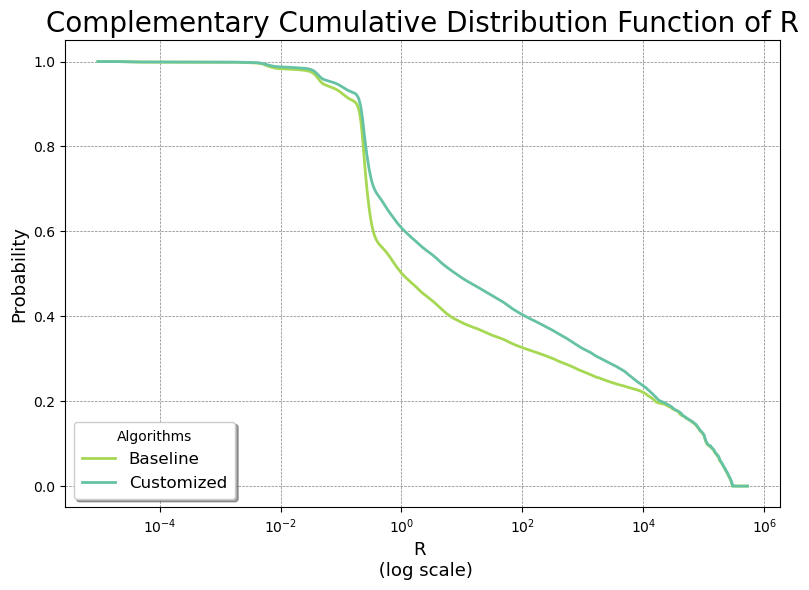

In [448]:
ecdf_2 = ECDF(R_2_values)
x_2 = np.sort(R_2_values)
y_2 = 1 - ecdf_2(x_2)

ecdf_1 = ECDF(R_1_values)
x_1 = np.sort(R_1_values)
y_1 = 1 - ecdf_1(x_1)

plt.figure(figsize=(8,6), tight_layout=True)
plt.style.use('default')
plt.xscale('log')
plt.plot(x_1, y_1, '-', linewidth=2, color = col[4], label = 'Baseline')
plt.plot(x_2, y_2, '-', linewidth=2, color = col[0], label = 'Customized')
plt.xlabel('R \n (log scale)', size=13)
plt.ylabel('Probability', size=13)
plt.title('Complementary Cumulative Distribution Function of R', size=20)
plt.legend(title='Algorithms', title_fontsize = 10, fontsize = 12,loc='lower left'
           ,fancybox=True, framealpha=1, shadow=True, borderpad=0.5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show()

### Eccdf for S

In [450]:
S_2_values = np.array(list(S_2.values()))
S_1_values = np.array(list(S_1.values()))

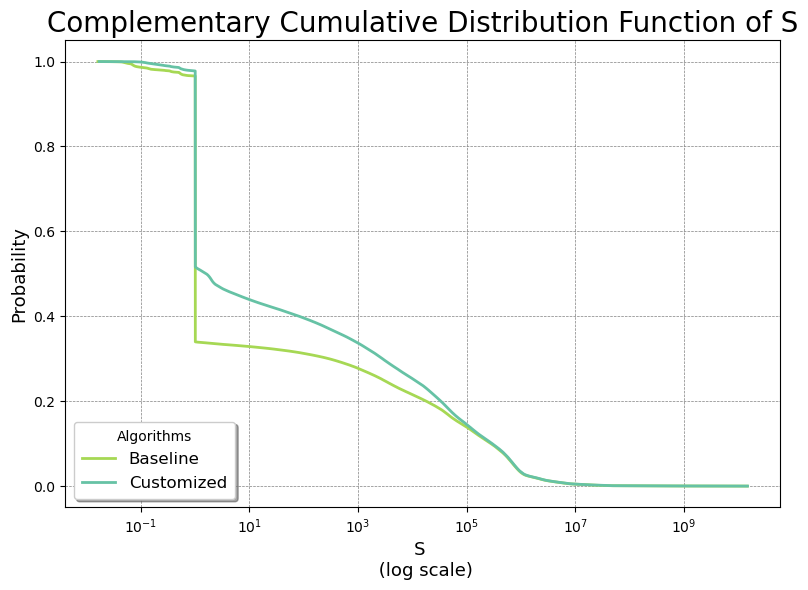

In [451]:
ecdf_2 = ECDF(S_2_values)
x_2 = np.sort(S_2_values)
y_2 = 1 - ecdf_2(x_2)

ecdf_1 = ECDF(S_1_values)
x_1 = np.sort(S_1_values)
y_1 = 1 - ecdf_1(x_1)

plt.figure(figsize=(8,6), tight_layout=True)
plt.style.use('default')
plt.xscale('log')
plt.plot(x_1, y_1, '-', linewidth=2, color = col[4], label = 'Baseline')
plt.plot(x_2, y_2, '-', linewidth=2, color = col[0], label = 'Customized')
plt.xlabel('S \n (log scale)', size=13)
plt.ylabel('Probability', size=13)
plt.title('Complementary Cumulative Distribution Function of S', size=20)
plt.legend(title='Algorithms', title_fontsize = 10, fontsize = 12,loc='lower left'
           ,fancybox=True, framealpha=1, shadow=True, borderpad=0.5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.show()

## Rho

In [51]:
rho = pd.DataFrame({'baseline' : list(rho_1.values()), 'custom' : list(rho_2.values())})

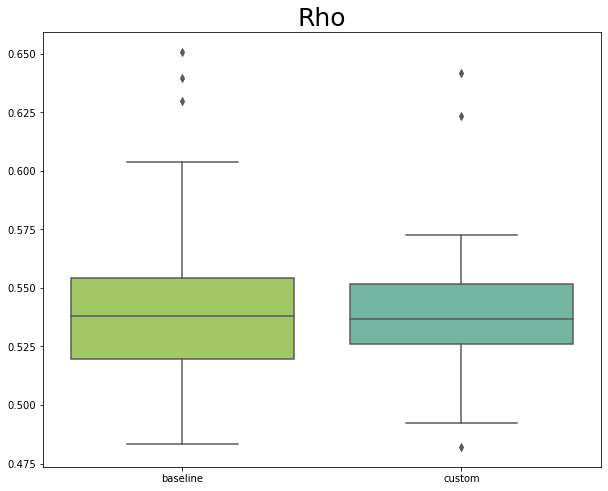

In [87]:
a4_dims = (10, 8)
fig, ax = plt.subplots(figsize=a4_dims)
rho_plot = sns.boxplot(data = rho, palette=[col[4], col[0]], ax=ax)
rho_plot.set(title='Rho')
rho_plot.title.set_fontsize(25) 